# Notebook 06 — Deep Learning (ANN) on Tabular Data

Goal: train a minimal ANN on the Breast Cancer dataset and compare Full versus Selected features.

We run two settings per feature set
- Baseline with no regularization
- Regularized using dropout weight decay and early stopping

We report test metrics using malignant class as the positive class for consistency with the explainability notebook.

Key outputs
- A results table comparing feature sets and regularization settings
- Loss curves saved in the figures folder
- Saved neural network weights and scalers in the models folder



## Setup and data preparation

Load the dataset, create a fixed train validation and test split, and define helper functions.
All artifacts are saved at the project root.



In [21]:
from pathlib import Path

ROOT_DIR = Path("..")
FIG_DIR = ROOT_DIR / "figures"
OUT_DIR = ROOT_DIR / "outputs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR = ROOT_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Import required libraries.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## Device and reproducibility

Select the compute device and set random seeds for reproducible runs.



In [22]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Use MPS on Apple Silicon if available, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: mps


In [23]:
# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0=malignant, 1=benign

print("X:", X.shape, "y:", y.shape)
print("Class counts:", y.value_counts())
print("Classes mapping: 0=malignant, 1=benign")

X: (569, 30) y: (569,)
Class counts: target
1    357
0    212
Name: count, dtype: int64
Classes mapping: 0=malignant, 1=benign


In [24]:
# Selected features (10) from your feature selection notebook
selected_features = [
    "mean texture",
    "mean concave points",
    "radius error",
    "fractal dimension error",
    "worst radius",
    "worst texture",
    "worst area",
    "worst smoothness",
    "worst concave points",
    "worst symmetry",
]

assert set(selected_features).issubset(set(X.columns)), "selected_features contain unknown column names."
print("Selected features:", len(selected_features))

Selected features: 10


In [25]:
# Create ONE split on indices, then reuse it for both feature sets (fair comparison)
idx_all = X.index

idx_train, idx_test, y_train, y_test = train_test_split(
    idx_all, y, test_size=0.2, random_state=SEED, stratify=y
)
idx_train, idx_val, y_train, y_val = train_test_split(
    idx_train, y.loc[idx_train], test_size=0.2, random_state=SEED, stratify=y.loc[idx_train]
)

print("Split sizes -> train:", len(idx_train), "val:", len(idx_val), "test:", len(idx_test))

Split sizes -> train: 364 val: 91 test: 114


## Preprocessing

Standardize numeric features using training data only to prevent data leakage.



In [26]:
def make_numpy(X_df: pd.DataFrame, idx, cols=None) -> np.ndarray:
    """Select rows by index and optionally a subset of columns."""
    if cols is None:
        return X_df.loc[idx].values.astype(np.float32)
    return X_df.loc[idx, cols].values.astype(np.float32)

def fit_scaler_and_transform(X_train_np, X_val_np, X_test_np):
    """Fit scaler on train only (avoid leakage), then transform val/test."""
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_np)
    X_val_s = scaler.transform(X_val_np)
    X_test_s = scaler.transform(X_test_np)
    return scaler, X_train_s.astype(np.float32), X_val_s.astype(np.float32), X_test_s.astype(np.float32)

def make_loader(X_np, y_series, batch_size=32, shuffle=False):
    X_t = torch.tensor(X_np, dtype=torch.float32)
    y_t = torch.tensor(y_series.values, dtype=torch.float32).view(-1, 1)  # BCE expects float targets
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 64, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)  # logits
        )

    def forward(self, x):
        return self.net(x)

def eval_loader(model, loader):
    """Return (acc, f1_malignant, auc_malignant, probs_benign) on a loader."""
    model.eval()
    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            all_logits.append(logits.cpu())
            all_y.append(yb.cpu())

    logits = torch.cat(all_logits).numpy().ravel()
    y_true = torch.cat(all_y).numpy().ravel()  # 0/1

    # Sigmoid to get P(class 1 = benign)
    probs_benign = 1.0 / (1.0 + np.exp(-logits))
    y_pred = (probs_benign >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)

    # Treat malignant (0) as positive for F1: pos_label=0
    f1_malignant = f1_score(y_true, y_pred, pos_label=0)

    # AUC for malignant: use y_true_malignant and P(malignant)=1-P(benign)
    y_true_malignant = (y_true == 0).astype(int)
    probs_malignant = 1.0 - probs_benign
    auc_malignant = roc_auc_score(y_true_malignant, probs_malignant)

    return acc, f1_malignant, auc_malignant, probs_benign

def train_model(model, train_loader, val_loader, epochs=300, lr=1e-3, weight_decay=0.0, patience=20):
    """Train with early stopping on validation loss. Returns history + best_state."""
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": [], "val_auc": []}

    best_val_loss = float("inf")
    best_state = None
    bad_epochs = 0

    for ep in range(1, epochs + 1):
        model.train()
        running = 0.0
        n = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running += loss.item() * xb.size(0)
            n += xb.size(0)

        train_loss = running / n

        # Validation loss
        model.eval()
        val_running = 0.0
        val_n = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_running += loss.item() * xb.size(0)
                val_n += xb.size(0)
        val_loss = val_running / val_n

        val_acc, val_f1, val_auc, _ = eval_loader(model, val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        history["val_auc"].append(val_auc)

        # Early stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history, best_val_loss

## Baseline training runs

Train the baseline model on full and selected features without regularization.



In [27]:
def run_ann_experiment(feature_set_name: str, cols=None, hidden=64, dropout=0.0, weight_decay=0.0,
                       epochs=300, lr=1e-3, patience=20, batch_size=32):
    """Train one ANN configuration on either full or selected features."""
    # Prepare numpy matrices
    Xtr = make_numpy(X, idx_train, cols=cols)
    Xva = make_numpy(X, idx_val, cols=cols)
    Xte = make_numpy(X, idx_test, cols=cols)

    # Scale using train only
    scaler, Xtr_s, Xva_s, Xte_s = fit_scaler_and_transform(Xtr, Xva, Xte)

    # Loaders
    train_loader = make_loader(Xtr_s, y.loc[idx_train], batch_size=batch_size, shuffle=True)
    val_loader = make_loader(Xva_s, y.loc[idx_val], batch_size=256, shuffle=False)
    test_loader = make_loader(Xte_s, y.loc[idx_test], batch_size=256, shuffle=False)

    # Model
    in_dim = Xtr_s.shape[1]
    model = MLP(in_dim=in_dim, hidden=hidden, dropout=dropout).to(device)

    # Train
    history, best_val_loss = train_model(
        model, train_loader, val_loader,
        epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience
    )

    # Test metrics
    test_acc, test_f1_m, test_auc_m, _ = eval_loader(model, test_loader)

    result = {
        "feature_set": feature_set_name,
        "n_features": in_dim,
        "dropout": dropout,
        "weight_decay": weight_decay,
        "best_val_loss": float(best_val_loss),
        "test_acc": float(test_acc),
        "test_f1_malignant": float(test_f1_m),
        "test_auc_malignant": float(test_auc_m),
        "history": history,
        "model": model,
        "scaler": scaler,
    }
    return result

# Run 4 experiments
results = []

# FULL features
results.append(run_ann_experiment("full", cols=None, hidden=128, dropout=0.0, weight_decay=0.0, patience=50))
results.append(run_ann_experiment("full", cols=None, hidden=64, dropout=0.3, weight_decay=1e-4, patience=20))

# SELECTED features
results.append(run_ann_experiment("selected", cols=selected_features, hidden=128, dropout=0.0, weight_decay=0.0, patience=50))
results.append(run_ann_experiment("selected", cols=selected_features, hidden=64, dropout=0.3, weight_decay=1e-4, patience=20))

# Build summary table
summary = pd.DataFrame([{
    "feature_set": r["feature_set"],
    "n_features": r["n_features"],
    "setting": "regularized" if (r["dropout"] > 0 or r["weight_decay"] > 0) else "baseline",
    "best_val_loss": r["best_val_loss"],
    "test_acc": r["test_acc"],
    "test_f1_malignant": r["test_f1_malignant"],
    "test_auc_malignant": r["test_auc_malignant"],
} for r in results])

summary = summary.sort_values(["feature_set", "setting"]).reset_index(drop=True)
display(summary)

try:
    summary.to_csv(OUT_DIR / "06_ann_full_vs_selected_results.csv", index=False)
    print("Saved:", OUT_DIR / "06_ann_full_vs_selected_results.csv")
except Exception as e:
    print("Could not save results table:", e)


,feature_set,n_features,setting,best_val_loss,test_acc,test_f1_malignant,test_auc_malignant
0,full,30,baseline,0.066263,0.956140,0.942529,0.994048
1,full,30,regularized,0.064884,0.956140,0.942529,0.992394
2,selected,10,baseline,0.059526,0.964912,0.952381,0.994378
3,selected,10,regularized,0.073754,0.956140,0.941176,0.994709


Saved: ../outputs/06_ann_full_vs_selected_results.csv


## Training loop

Train the network and track train and validation loss. Early stopping uses validation loss.



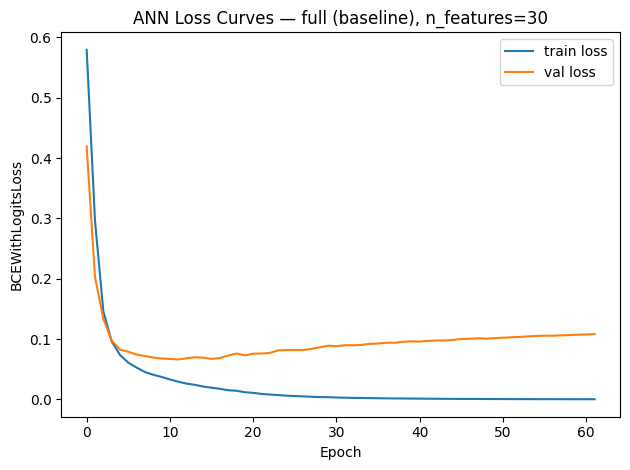

Saved: ../figures/06_loss_full_baseline_30f.png


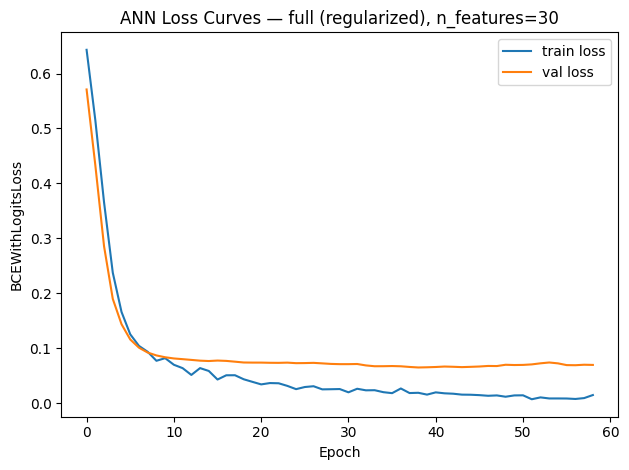

Saved: ../figures/06_loss_full_regularized_30f.png


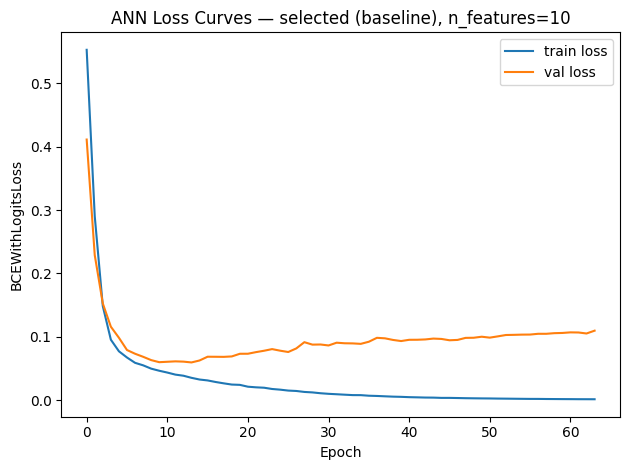

Saved: ../figures/06_loss_selected_baseline_10f.png


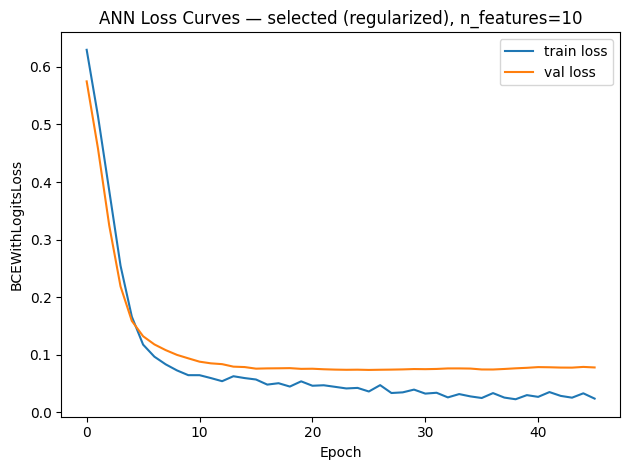

Saved: ../figures/06_loss_selected_regularized_10f.png


In [28]:
# Plot and save loss curves
def plot_loss_curves(res, title, filename):
    plt.figure()
    plt.plot(res["history"]["train_loss"], label="train loss")
    plt.plot(res["history"]["val_loss"], label="val loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("BCEWithLogitsLoss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / filename, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", FIG_DIR / filename)

for r in results:
    setting = "regularized" if (r["dropout"] > 0 or r["weight_decay"] > 0) else "baseline"
    title = f"ANN Loss Curves — {r['feature_set']} ({setting}), n_features={r['n_features']}"
    filename = f"06_loss_{r['feature_set']}_{setting}_{r['n_features']}f.png"
    plot_loss_curves(r, title, filename)



## Save artifacts

Save the trained network weights and preprocessing scalers for reproducibility.



In [29]:
import joblib
import torch
from pathlib import Path

# Ensure the models directory exists
MODEL_DIR = Path(MODEL_DIR)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

def save_run(res, prefix):
    # Save the fitted scaler
    joblib.dump(res["scaler"], MODEL_DIR / f"{prefix}_scaler.pkl")

    # Save the ANN weights
    torch.save(res["model"].state_dict(), MODEL_DIR / f"{prefix}_ann.pt")

# Pick best regularized run per feature set based on best validation loss
reg_runs = [r for r in results if (r.get("dropout", 0) > 0 or r.get("weight_decay", 0) > 0)]
best_full = min([r for r in reg_runs if r["feature_set"] == "full"], key=lambda d: d["best_val_loss"])
best_sel = min([r for r in reg_runs if r["feature_set"] == "selected"], key=lambda d: d["best_val_loss"])

save_run(best_full, "full_regularized")
save_run(best_sel, "selected_regularized")

print("Saved:")
print("-", MODEL_DIR / "full_regularized_scaler.pkl")
print("-", MODEL_DIR / "full_regularized_ann.pt")
print("-", MODEL_DIR / "selected_regularized_scaler.pkl")
print("-", MODEL_DIR / "selected_regularized_ann.pt")

Saved:
- ../models/full_regularized_scaler.pkl
- ../models/full_regularized_ann.pt
- ../models/selected_regularized_scaler.pkl
- ../models/selected_regularized_ann.pt
